In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, join, select

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

### Design a query to retrieve the last 12 months of precipitation data and plot the data

In [13]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
measurements_full = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()
all_ly = [measurement for measurement in measurements_full]
measurements_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()
prcp_ly = [measurement for measurement in measurements_prcp]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_df = pd.DataFrame(all_ly).dropna()
measurements_df.set_index(['date'])
measurements_prcp = pd.DataFrame(prcp_ly).dropna()
measurements_prcp.set_index(['date'])

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


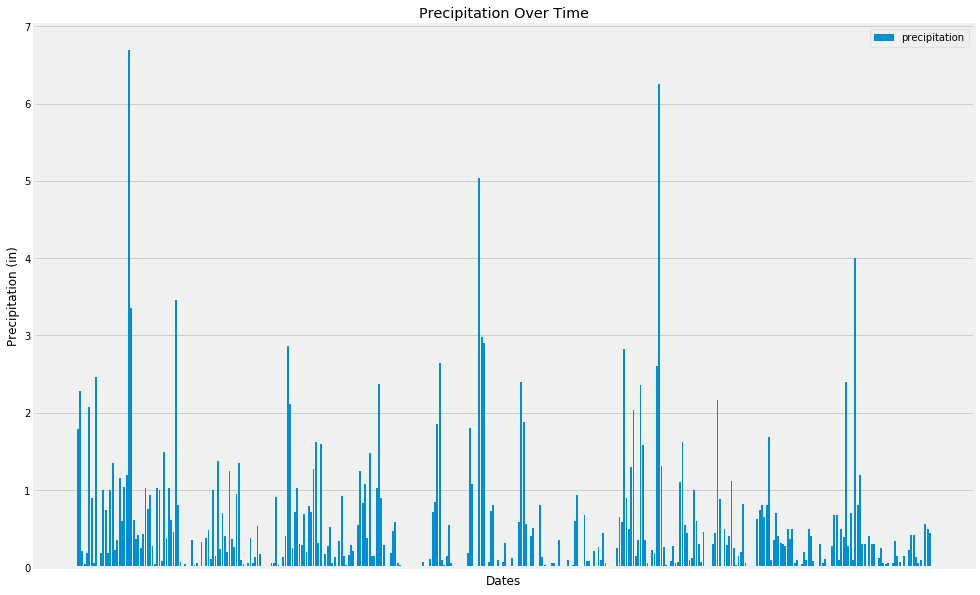

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x=measurements_prcp['date'], height=measurements_prcp['prcp'], label='precipitation');
ax.set_xticklabels([]);
ax.legend();
ax.grid(axis='x');
ax.set(xlabel='Dates', ylabel='Precipitation (in)', title='Precipitation Over Time');

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
stations = session.query(distinct(Measurement.station)).all()
stations

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [19]:
# List the stations and the counts in descending order.
station_counts = session.query(
    Measurement.station, func.count(Measurement.station)
).group_by(
    Measurement.station
).having(
    func.count(Measurement.station) > 1
).order_by(func.count(Measurement.station).desc())
print(station_counts.all())

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Which station has the most observations
print(station_counts.first()[0])

USC00519281


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station_stats = session.query(
    Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)
).filter(Measurement.station == station_counts.first()[0]).all()
print(top_station_stats)

[('USC00519281', 85.0, 54.0, 71.66378066378067)]


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bins =[57, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 83]
group_names = np.arange(59, 83, 2)


measurements_df["grouped_tobs"] = pd.cut(measurements_df["tobs"], bins, labels=group_names)
measurements_df

,station,date,prcp,tobs,grouped_tobs
0,USC00519397,2016-08-23,0.00,81.0,81
1,USC00513117,2016-08-23,0.15,76.0,75
2,USC00514830,2016-08-23,0.05,80.0,79
4,USC00519523,2016-08-23,0.02,80.0,79
5,USC00519281,2016-08-23,1.79,77.0,77
...,...,...,...,...,...
2225,USC00516128,2017-08-22,0.50,76.0,75
2226,USC00519397,2017-08-23,0.00,81.0,81
2227,USC00514830,2017-08-23,0.00,82.0,81
2228,USC00519523,2017-08-23,0.08,82.0,81


In [23]:
top_station_df = measurements_df[measurements_df.station == station_counts.first()[0]]
top_station_df.sort_values(by="tobs", ascending=True )

,station,date,prcp,tobs,grouped_tobs
1036,USC00519281,2017-02-02,0.00,59.0,59
1074,USC00519281,2017-02-08,0.00,59.0,59
1081,USC00519281,2017-02-09,0.00,59.0,59
1578,USC00519281,2017-04-30,1.04,60.0,59
1043,USC00519281,2017-02-03,0.00,60.0,59
...,...,...,...,...,...
1266,USC00519281,2017-03-11,0.01,81.0,81
2125,USC00519281,2017-07-29,0.23,82.0,81
2085,USC00519281,2017-07-23,0.20,82.0,81
2156,USC00519281,2017-08-05,0.06,82.0,81


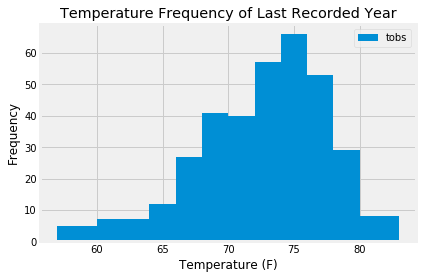

In [24]:
fig2, ax2 = plt.subplots()
ax2.hist(top_station_df["grouped_tobs"],bins, label="tobs")
ax2.legend();
ax2.set(xlabel="Temperature (F)", ylabel="Frequency", title="Temperature Frequency of Last Recorded Year");

In [26]:
from werkzeug.wrappers import Request, Response
from flask import Flask, jsonify, request

In [27]:
app = Flask(__name__)

In [28]:
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/?start=(INPUT START DATE HERE)&end=(INPUT END DATE HERE)<br/>"
    )

In [29]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of precipitation data"""
    # Query precipitation from latest year
    results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

    session.close()

    # Create a dictionary from the row data and append to a list of all_passengers
    all_prcp = []
    for date, prcp in results:
        prcp_dict = {}
        prcp_dict["date"] = date
        prcp_dict["prcp"] = prcp
        all_prcp.append(prcp_dict)

    return jsonify(all_prcp)

In [30]:
@app.route("/api/v1.0/stations")
def stations():
    
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all stations"""
    # Query all stations
    results = session.query(distinct(Measurement.station)).all()

    session.close()

    # Convert list of tuples into normal list
    all_stations = list(np.ravel(results))

    return jsonify(all_stations)  


In [31]:
@app.route("/api/v1.0/tobs")
def tobs():

    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of tobs data"""
    # Query tobs from latest year
    results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

    session.close()

    # Create a dictionary from the row data and append to a list of tobs
    all_tobs = []
    for date, tobs in results:
        tobs_dict = {}
        tobs_dict["date"] = date
        tobs_dict["tobs"] = tobs
        all_tobs.append(tobs_dict)

    return jsonify(all_tobs)

In [32]:
# URL will appear in /api/v1.0/?start=(INPUT START DATE HERE)&end=(INPUT END DATE HERE) format
@app.route('/api/v1.0/')
def start_end():
    start = request.args.get('start')
    end = request.args.get('end')
    
    # Create our session (link) from Python to the DB
    session = Session(engine)
    
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    session.close()

    # Create a dictionary from the row data and append to a list of all_passengers
    temp_stats = list(np.ravel(results))

    return jsonify(temp_stats)

In [33]:
#URL will appear in /api/v1.0/?start=(INPUT START DATE HERE) format
@app.route('/api/v1.0/')
def start_only():
    start = request.args.get('start')
    
    # Create our session (link) from Python to the DB
    session = Session(engine)
    
    results_start_only = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start).all()

    session.close()

    # Create a dictionary from the row data and append to a list of all_passengers
    temp_stats = list(np.ravel(results))

    return jsonify(temp_stats)

In [34]:
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

 * Running on http://localhost:9000/ (Press CTRL+C to quit)


In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-05-14'
trip_end = '2017-05-21'
trip_stats = calc_temps(trip_start, trip_end)
trip_min = trip_stats[0][0]
trip_avg = trip_stats[0][1]
trip_max = trip_stats[0][2]
trip_stats

[(68.0, 74.5909090909091, 80.0)]

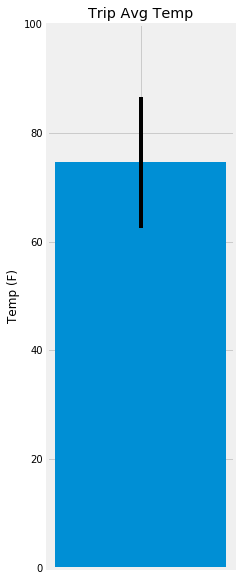

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig3, ax3 = plt.subplots(figsize=(3,10))
ax3.bar(x="",height=trip_avg, yerr=(trip_max-trip_min), width = 1);
ax3.set(ylim=(0,100), title= "Trip Avg Temp", ylabel="Temp (F)");

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
joined = (
    session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.date, Measurement.prcp)
    .join(Measurement, Station.station == Measurement.station)
    .filter(Measurement.date >= trip_start)
    .filter(Measurement.date <= trip_end)
    .order_by(Measurement.prcp.desc())
    .all()
)
# stmt = select([Station]).select_from(joined)
# result = conn.execute(stmt)
# result.fetchall()
for j in joined:
    print(j)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, '2017-05-14', 1.0)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, '2017-05-15', 0.6)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, '2017-05-18', 0.46)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, '2017-05-16', 0.3)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, '2017-05-14', 0.17)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, '2017-05-18', 0.16)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, '2017-05-18', 0.13)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, '2017-05-18', 0.09)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, '2017-05-15', 0.09)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, '2017-05-15', 0.08)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157